In [2]:
from gerrychain import updaters, Graph, constraints, GeographicPartition, proposals, tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [3]:
graph = Graph.from_file("./VA_MUNI_DATA/va_precincts_all.shp")
print("Loaded graph")


C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(309, 320), (307, 320), (308, 309)}
  overlaps


Loaded graph


C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\gerrychain\graph\graph.py:249: UserWarning: NA values found in column G17DGOV!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\gerrychain\graph\graph.py:249: UserWarning: NA values found in column G16OHOR!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\gerrychain\graph\graph.py:249: UserWarning: NA values found in column notes!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\gerrychain\graph\graph.py:249: UserWarning: NA values found in column explain!
  warnings.warn("NA values found in column {}!".format(column))


In [4]:
print("Sample node data: ")
print(print(graph.nodes[0]))

Sample node data: 
{'boundary_node': False, 'area': 13171012.745633002, 'precinct': 'Titustown', 'locality': 'Norfolk', 'loc_prec': 'Norfolk Titustown', 'district': 'Congressional District 2', 'G18DHOR': '666.0', 'G18DSEN': '680.0', 'G18OHOR': '0.0', 'G18OSEN': '12.0', 'G18RHOR': '87.0', 'G18RSEN': '68.0', 'G17DGOV': '516.0', 'G17DLTG': '519.0', 'G17DATG': '510.0', 'G17DHOD': '533.0', 'G17RGOV': '54.0', 'G17RLTG': '63.0', 'G17RATG': '70.0', 'G17RHOD': '0.0', 'G17OHOD': '0.0', 'G17OGOV': '11.0', 'G16DPRS': '772.0', 'G16RPRS': '135.0', 'G16OPRS': '49.0', 'G16DHOR': '780.0', 'G16RHOR': '149.0', 'G16OHOR': '0.0', 'notes': None, 'explain': None, 'TOTPOP': 8728, 'WHITE': 3234, 'AMIN': 74, 'ASIAN': 213, 'NHPI': 27, 'OTHER': 311, '2MORE': 529, 'VAP': 5943, 'DLS_BVAP': 2237, 'DLS_NONB': 3706, 'DOJ_BVAP': 2237, 'DOJ_NONB': 3706, 'SENPER': 0.909, 'ATGperc': 0.879, 'geometry': <shapely.geometry.polygon.Polygon object at 0x000001B46A2B7C88>}
None


In [5]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "BVAP": updaters.Tally("DOJ_BVAP", alias="BVAP"),
    "VAP": updaters.Tally("VAP", alias="VAP")
}
initial_partition = GeographicPartition(graph, assignment="district", updaters=my_updaters)
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
num_districts = len(initial_partition)
dict_BVAP = {d : float(sum(
    [graph.nodes[n]["DOJ_BVAP"] for n in initial_partition.parts[d]]))/float(sum(
    [graph.nodes[n]["VAP"] for n in initial_partition.parts[d]])) for d in initial_partition.parts}

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

In [9]:
#What does this section do? Thomas told us to comment out
# BVAPS = []
# counter = 0
# for sample in range(0,3000):
#     counter += 1
#     if counter % 50 == 0:
#         print(counter, end=" ")
#     district = tree.bipartition_tree(graph, "TOTPOP", ideal_population, 0.02, 2)
#     BVAP = sum([graph.nodes[n]["DOJ_BVAP"] for n in district])
#     VAP = sum([graph.nodes[n]["VAP"] for n in district])
#     BVAPS.append(BVAP/VAP)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 1050 1100 1150 1200 1250 1300 1350 1400 1450 1500 1550 1600 1650 1700 1750 1800 1850 1900 1950 2000 2050 2100 2150 2200 2250 2300 2350 2400 2450 2500 2550 2600 2650 2700 2750 2800 2850 2900 2950 3000 

In [13]:
df_real = pd.read_csv("./VA_BVAP/DOJBVAP_2000.csv", header=None)
for x in range(4000,100001,2000):
    df_real = pd.concat([df_real, pd.read_csv("./VA_BVAP/DOJBVAP_{0}.csv".format(x), header=None)], ignore_index=True)
#BVAPS should be 1 long list of 11 BVAPS per row times number of rows
BVAPS = []
for j in range(11):
    for i in range(len(df_real.index)):
        ij = df_real.get_value(i,j)
        BVAPS.append(ij)

C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


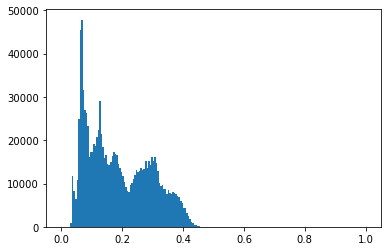

In [19]:
n_bins = 200
hist = plt.hist(BVAPS, bins=np.linspace(0, 1, n_bins+1, endpoint=True))
pdf = [x/sum(BVAPS) for x in hist[0]]


In [20]:
class BVAP_pdf(st.rv_continuous):
    def _pdf(self,x):
        return pdf[np.digitize(x, np.linspace(0, 1, n_bins))-1]

BVAPPDF = BVAP_pdf()

In [21]:
###MCMC time
vector = list(dict_BVAP.values())
print("Starting vector: ", vector)

counter = 0
list_of_vector_dicts = []
for step in range(0, 100000):
    [position1, position2] = np.random.choice(range(num_districts), size=2, replace=False)
    random01 = np.random.random()
    sum_of_positions = vector[position1]+vector[position2]
    proposal = [sum_of_positions*random01, sum_of_positions*(1-random01)]
    random_for_accept = np.random.random()
    alpha = BVAPPDF._pdf(proposal[0])*BVAPPDF._pdf(proposal[1])/(BVAPPDF._pdf(vector[position1])*BVAPPDF._pdf(vector[position2]))
    if (random_for_accept <= alpha):
        vector[position1] = proposal[0]
        vector[position2] = proposal[1]
    vector_dict = {x: sorted(vector)[x] for x in range(0, len(vector)) }
    counter += 1
    if counter > 1000:
        list_of_vector_dicts.append(vector_dict)
    
df = pd.DataFrame(list_of_vector_dicts)

Starting vector:  [0.1913996875828937, 0.4400019684451217, 0.10385156678342314, 0.05103286288668253, 0.20158574259632697, 0.13299328554562032, 0.1774155956888056, 0.16136410399611997, 0.4055859416352024, 0.0678184302765468, 0.11924110827848675]


Done generating simulated boxplot...
Done generating real boxplot...


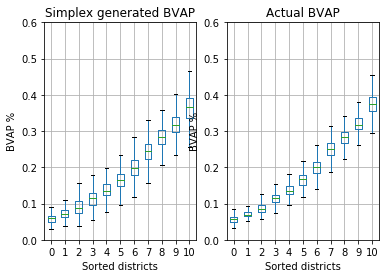

In [25]:
fig = plt.figure()
ax = plt.subplot(1,2,1)

# Draw 50% line
ax.set_title("Simplex generated BVAP")
ax.set_ylabel("BVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 0.6)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Draw boxplot
bp = df.boxplot(ax=ax, showfliers=False)
print("Done generating simulated boxplot...")

ax2 = plt.subplot(1,2,2)
bp_real = df_real.boxplot(ax=ax2, showfliers=False)
print("Done generating real boxplot...")
ax2.set_title("Actual BVAP")
ax2.set_ylabel("BVAP %")
ax2.set_xlabel("Sorted districts")
ax2.set_ylim(0, 0.6)
ax2.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])


# Annotate


plt.show()
fig.savefig("Comparing_simplex_to_actual_VA.png")

In [43]:
#From Bhushan: The following code calculates the BVAP % in each district and sorts them into a list
#initial_partition is enacted we think
#dict_BVAP is BVAP percents that thomas stored in dictionary (BVAP% = BVAP/VAP)

dict_BVAP_list = sorted(dict_BVAP.values())
total_BVAP = 0
# find the gap between each district
num_gaps = 10
enacted_gaps = []
for i in range(num_gaps):
    enacted_gaps.append(dict_BVAP_list[i+1] - dict_BVAP_list[i])
enacted_gaps

[0.016785567389864267,
 0.03603313650687634,
 0.015389541495063608,
 0.01375217726713357,
 0.028370818450499657,
 0.016051491692685632,
 0.013984091894088085,
 0.010186055013433282,
 0.20400019903887542,
 0.03441602680991929]

[0.05103286288668253, 0.0678184302765468, 0.10385156678342314, 0.11924110827848675, 0.13299328554562032, 0.16136410399611997, 0.1774155956888056, 0.1913996875828937, 0.20158574259632697, 0.4055859416352024, 0.4400019684451217]


C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mackenzie\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


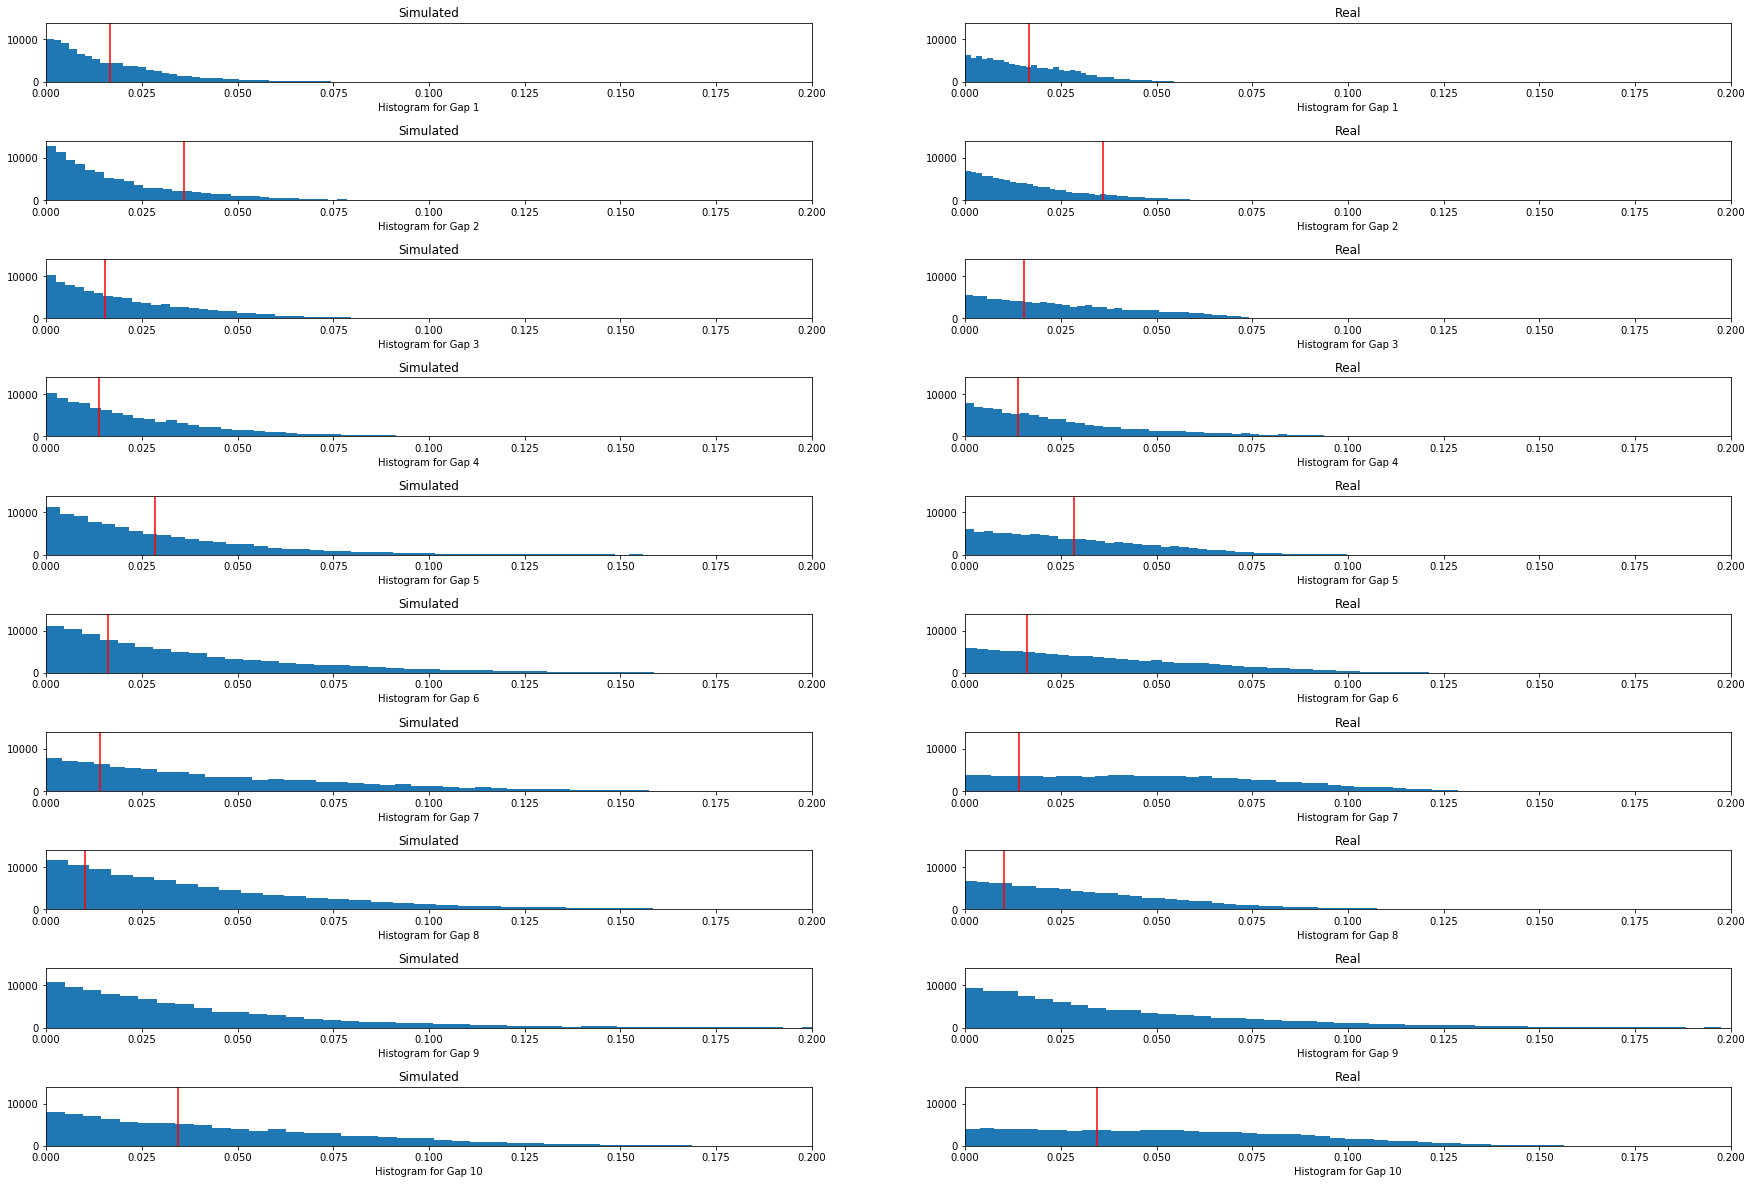

In [44]:
#df is simulated (pdf created from pooling all ensemble BVAPS)
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

index = 0
for j in range(10):
    gaps_sim=[]
    gaps_real=[]
    for i in range(len(df.index)):
        gap_sim = df.get_value(i,j+1) - df.get_value(i,j)
        gap_real = df_real.get_value(i,j+1) - df_real.get_value(i,j)
        gaps_sim.append(gap_sim)
        gaps_real.append(gap_real)
    index += 1
    
    plt.subplot(10,2,index*2-1, ylim=(0, 14000), xlim=(0,.2))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=4, wspace=None, hspace=1)
    plt.hist(gaps_sim, bins=50)
    plt.xlabel('Histogram for Gap ' + str(index))
    plt.title('Simulated')
    plt.axvline(x=enacted_gaps[j], color="red")
    
    plt.subplot(10,2,index*2, ylim=(0, 14000), xlim=(0,.2))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=4, top=4, wspace=None, hspace=1)
    plt.hist(gaps_real, bins=50)
    plt.xlabel('Histogram for Gap ' + str(index))
    plt.title('Real')
    plt.axvline(x=enacted_gaps[j], color="red")